In [6]:
import json
import urllib.request

url = "http://api.fixer.io/2014-01-03"
response_bytes = urllib.request.urlopen(url).read()
print(response_bytes)

data = json.loads(response_bytes)
print(data["rates"]["CHF"])

b'{"base":"EUR","date":"2014-01-03","rates":{"AUD":1.5156,"BGN":1.9558,"BRL":3.2373,"CAD":1.4468,"CHF":1.2309,"CNY":8.2569,"CZK":27.525,"DKK":7.4586,"GBP":0.83045,"HKD":10.573,"HRK":7.628,"HUF":298.66,"IDR":16533.0,"ILS":4.7749,"INR":84.802,"JPY":142.46,"KRW":1438.7,"LTL":3.4528,"MXN":17.821,"MYR":4.476,"NOK":8.3585,"NZD":1.6434,"PHP":60.892,"PLN":4.1658,"RON":4.4879,"RUB":45.139,"SEK":8.8561,"SGD":1.7244,"THB":45.022,"TRY":2.9637,"USD":1.3634,"ZAR":14.439}}'
1.2309


In [56]:
import time

def fetch_exchange_rate(year, month, day, _cache={}):
    date_str = "{:4d}-{:02d}-{:02d}".format(year, month, day)
    if date_str in _cache:
        print("cache hit !")
        return _cache[date_str]
    url = "http://api.fixer.io/{}".format(date_str)
    response_bytes = urllib.request.urlopen(url).read()
    data = json.loads(response_bytes)
    result = data["rates"]["CHF"]
    _cache[date_str] = result
   
    return result


print(fetch_exchange_rate(2015, 1, 1))
print(fetch_exchange_rate(2017, 12, 1))
print(fetch_exchange_rate(2017, 12, 1))
print(fetch_exchange_rate(2017, 12, 1))   

1.2024
1.1691
cache hit !
1.1691
cache hit !
1.1691


In [63]:
from functools import wraps

def cache(function):
    cache = {}
    def wrapped(*args, **kwargs):
        key = args + tuple(kwargs.items())
        if key not in cache:
            print("key", key, "not in cache")
            cache[key] = function(*args, **kwargs)
        return cache[key]
    return wrapped



def fetch_exchange_rate(year, month, day, _cache={}):
    date_str = "{:4d}-{:02d}-{:02d}".format(year, month, day)
    url = "http://api.fixer.io/{}".format(date_str)
    response_bytes = urllib.request.urlopen(url).read()
    data = json.loads(response_bytes)
    return data["rates"]["CHF"]


fetch_exchange_rate = cache(fetch_exchange_rate)

print(fetch_exchange_rate(2017, 12, 1))
print(fetch_exchange_rate(2017, 12, 1))
print(fetch_exchange_rate(2017, 12, 1))

key (2017, 12, 1) not in cache
1.1691
1.1691
1.1691


In [64]:
@cache
def fetch_exchange_rate(year, month, day, _cache={}):
    date_str = "{:4d}-{:02d}-{:02d}".format(year, month, day)
    url = "http://api.fixer.io/{}".format(date_str)
    response_bytes = urllib.request.urlopen(url).read()
    data = json.loads(response_bytes)
    return data["rates"]["CHF"]

print(fetch_exchange_rate(2015, 1, 1))
print(fetch_exchange_rate(2017, 12, 1))
print(fetch_exchange_rate(2017, 12, 1))
print(fetch_exchange_rate(2017, 12, 1))
    

key (2015, 1, 1) not in cache
1.2024
key (2017, 12, 1) not in cache
1.1691
1.1691
1.1691


In [65]:
def to_list(generator):
    def wrapped(*args, **kwargs):
        return list(generator(*args, **kwargs))
    return wrapped

In [66]:
from datetime import datetime

@to_list
def first_month_rates():
    for year in (2015, 2016, 2017):
        for month in range(1, 13):
            yield datetime(year, month, 1), fetch_exchange_rate(year, month, 1)
            


key (2015, 2, 1) not in cache
key (2015, 3, 1) not in cache
key (2015, 4, 1) not in cache
key (2015, 5, 1) not in cache
key (2015, 6, 1) not in cache
key (2015, 7, 1) not in cache
key (2015, 8, 1) not in cache
key (2015, 9, 1) not in cache
key (2015, 10, 1) not in cache
key (2015, 11, 1) not in cache
key (2015, 12, 1) not in cache
key (2016, 1, 1) not in cache
key (2016, 2, 1) not in cache
key (2016, 3, 1) not in cache
key (2016, 4, 1) not in cache
key (2016, 5, 1) not in cache
key (2016, 6, 1) not in cache
key (2016, 7, 1) not in cache
key (2016, 8, 1) not in cache
key (2016, 9, 1) not in cache
key (2016, 10, 1) not in cache
key (2016, 11, 1) not in cache
key (2016, 12, 1) not in cache
key (2017, 1, 1) not in cache
key (2017, 2, 1) not in cache
key (2017, 3, 1) not in cache
key (2017, 4, 1) not in cache
key (2017, 5, 1) not in cache
key (2017, 6, 1) not in cache
key (2017, 7, 1) not in cache
key (2017, 8, 1) not in cache
key (2017, 9, 1) not in cache
key (2017, 10, 1) not in cache
key

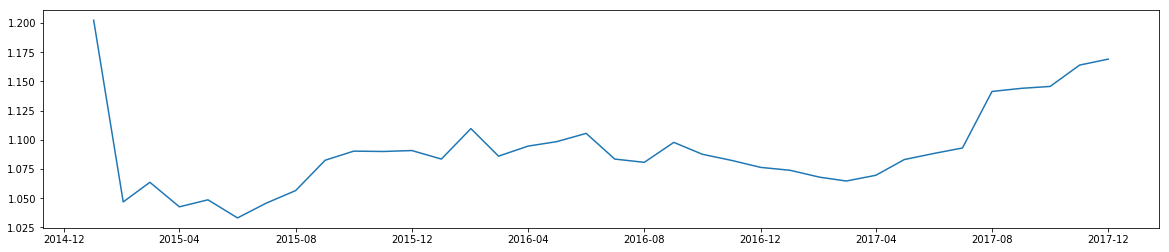

In [67]:
from matplotlib import pylab

dates_and_rates = first_month_rates()
dates = [date for (date, rate) in dates_and_rates]
rates = [rate for (date, rate) in dates_and_rates]

pylab.figure(figsize=(20,4))
pylab.plot(dates, rates)
pylab.show()

In [78]:
from statistics import mean
import time

def is_leap_year(year):
    if year % 400 == 0:
        return True
    if year % 100 == 0:
        return False
    return year % 4 == 0


def last_day(year, month):
    if month == 2:
        return 29 if is_leap_year(year) else 28
    if month in (1, 3, 5, 7, 8, 10, 12):
        return 31
    return 30

@cache
def monthly_average_exchange_rate(year, month):
    rates = []
    for day in range(1, last_day(year, month) + 1):
        rates.append(fetch_exchange_rate(year, month, day))
        time.sleep(.2)
       
    return datetime(year, month, 1), mean(rates)

monthly_average_exchange_rate(2016, 1)    

key (2016, 1) not in cache


(datetime.datetime(2016, 1, 1, 0, 0), 1.093974193548387)

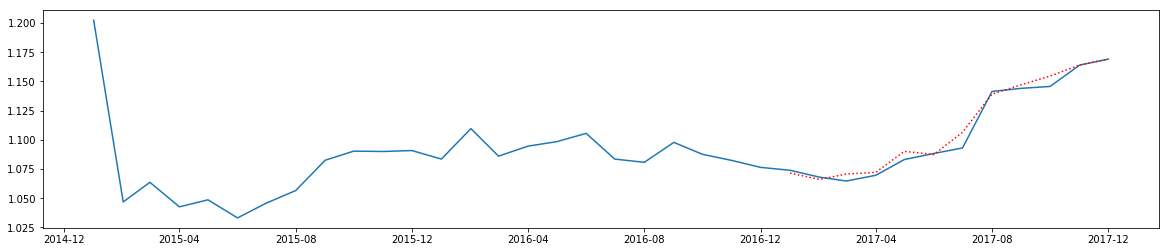

In [80]:
dates_and_rates = first_month_rates()
dates = [date for (date, rate) in dates_and_rates]
rates = [rate for (date, rate) in dates_and_rates]

pylab.figure(figsize=(20,4))
pylab.plot(dates, rates)

while True:
    try:
        dates_and_rates = [monthly_average_exchange_rate(2017, month) for month in range(1, 13)]
    except urllib.request.HTTPError:
        print("try again")
        time.sleep(3)
        continue
    break
    

dates = [date for (date, rate) in dates_and_rates]
rates = [rate for (date, rate) in dates_and_rates]

pylab.plot(dates, rates, "r:")
pylab.show()